In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

# Exercise 2
### Sutton & Barto Example 4.2: Jack’s Car Rental

In [2]:
POISSON_CACHE = defaultdict(int)        # Cache for Poisson Distribution
GAMMA = 0.9                             # Discount Factor
MAX_CARS = 20                           # Max number of cars in each location 
MAX_MOVE = 5                            # Max number of cars to move in each night
RENTAL_REWARD = 10                      # Reward for each car rented
MOVE_COST = 2                           # Cost for each car moved
RENTAL_LAMBDA = [3, 4]                  # Poisson Distribution lambda for rental requests of each location
RETURN_LAMBDA = [3, 2]                  # Poisson Distribution lambda for return requests of each location
THETA = 1e-3                            # Convergence threshold

In [3]:
def poisson_probability(k, lam):
    """
    Store the probability mass function of the Poisson distribution
    Return the probability of k occurring given the expected number lam.
    """
    global POISSON_CACHE
    key = (k, lam)
    if key not in POISSON_CACHE:
        POISSON_CACHE[key] = (lam**k * np.exp(-lam)) / np.math.factorial(k)
    return POISSON_CACHE[key]
    

In [4]:
def get_reward(state):
    global R_1, R_2
    return R_1[state[0]] + R_2[state[1]]

In [5]:
def transition_probability(state, new_state):
    global P_1, P_2
    return P_1[(state[0], new_state[0])] * P_2[(state[1], new_state[1])]

In [6]:
def calculate_reward_and_probability(loc):
    global MAX_CARS, MAX_MOVE, RENTAL_REWARD, MOVE_COST, RENTAL_LAMBDA, RETURN_LAMBDA
    r, p = defaultdict(int), defaultdict(int)
    for requested in range(MAX_CARS + 1):
        p1 = poisson_probability(requested, RENTAL_LAMBDA[loc])
        for k in range(MAX_CARS + 1):
            if k not in r:
                r[k] = 0.0
            r[k] += p1 * min(k, requested) * RENTAL_REWARD
        for returned in range(MAX_CARS + 1):
            p2 = poisson_probability(returned, RETURN_LAMBDA[loc])
            for k in range(MAX_CARS + 1):
                new_k = max(0, min(MAX_CARS, k - min(k, requested) + returned))
                if (k, new_k) not in p:
                    p[(k, new_k)] = 0.0
                p[(k, new_k)] += p1 * p2
    return r, p


In [7]:
def expectation_reward(state, action, value):
    
    global MOVE_COST, MAX_CARS

    a = max(-state[1], min(action, state[0]))
    a = max(-MAX_MOVE, min(a, MAX_MOVE))

    s = [state[0] - a if state[0] - a < MAX_CARS else MAX_CARS, state[1] + a if state[1] + a < MAX_CARS else MAX_CARS]
    
    r = get_reward(s)

    v = 0.0
    v -= MOVE_COST * abs(a)
    
    for ss1 in range(MAX_CARS + 1):
        for ss2 in range(MAX_CARS + 1):
            v += transition_probability(s, [ss1, ss2]) * (r + GAMMA * value[ss1, ss2])

    return v


In [8]:
def plot(policy, value, iteration):
    global MAX_CARS, MAX_MOVE

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    
    # 3D plot of the value function
    ax[0] = fig.add_subplot(1, 2, 1, projection='3d')
    
    X = np.arange(0, value.shape[0], 1)
    Y = np.arange(0, value.shape[1], 1)
    X, Y = np.meshgrid(X, Y)
    Z = value[X, Y]
    
    ax[0].set_xlabel('Cars at location 1')
    ax[0].set_ylabel('Cars at location 2')
    ax[0].set_zlabel('Value')
    ax[0].set_title(f"Value table V_π_{iteration}")
    ax[0].plot_surface(X, Y, Z, cmap='viridis')
    
    # 2D heatmap for policy
    actions = list(range(-MAX_MOVE, MAX_MOVE + 1))
    cmaplist = [plt.cm.RdBu(i) for i in range(plt.cm.RdBu.N)]
    dRbBu = matplotlib.colors.LinearSegmentedColormap.from_list('dRdBu', cmaplist, plt.cm.RdBu.N)
    
    sns.heatmap(policy, vmin=-5, vmax=5, cmap=dRbBu, ax=ax[1], cbar_kws={"ticks": actions, "boundaries": actions})
    ax[1].set_ylim(0, MAX_CARS)
    ax[1].set_title(f"Policy π_{iteration}")

    plt.tight_layout()
    plt.show()

    return 

In [9]:
R_1, P_1 = calculate_reward_and_probability(0)
R_2, P_2 = calculate_reward_and_probability(1)

#### Policy Iteration

In [10]:
def policy_iteration():
    # Initialization
    global MAX_CARS, MAX_MOVE, THETA
    value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)
    iteration = 0
    plot(policy, value, iteration)
    
    while True: 
        # Policy Evaluation
        while True:
            old_value = np.copy(value)
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                    state = [i, j]
                    action = policy[i, j]
                    value[i, j] = expectation_reward(state, action, old_value)
            delta = np.max(np.abs(value - old_value))
            if delta < THETA:
                break

        # Policy Improvement
        policy_stable = True
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                state = [i, j]
                old_action = policy[i, j]
                action_list = [i for i in range(-min(state[1], MAX_MOVE), min(state[0], MAX_MOVE) + 1)]
                best_value = np.argmax([expectation_reward(state, a, value) for a in action_list])
                policy[i, j] = action_list[best_value]
                if old_action != policy[i, j]:
                    policy_stable = False
        iteration += 1
        if policy_stable:
            break
        
        plot(policy, value, iteration)
        
    return

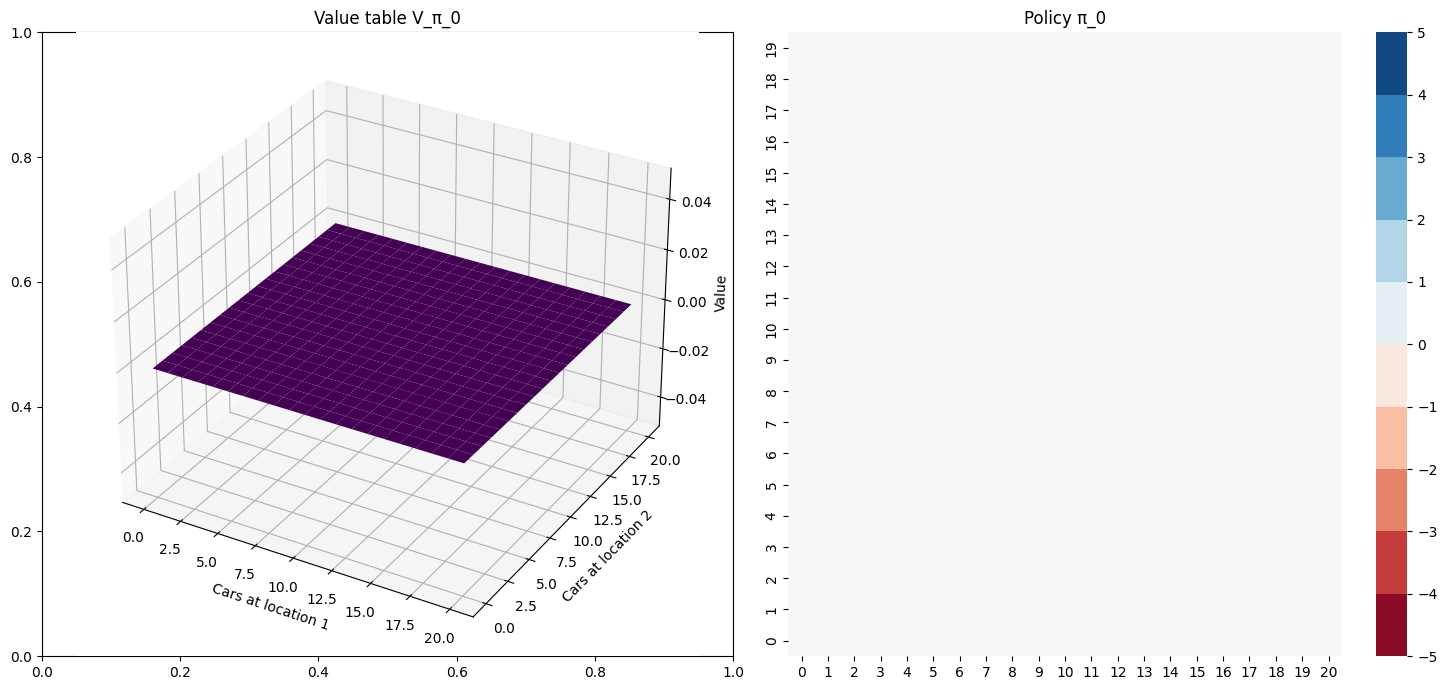

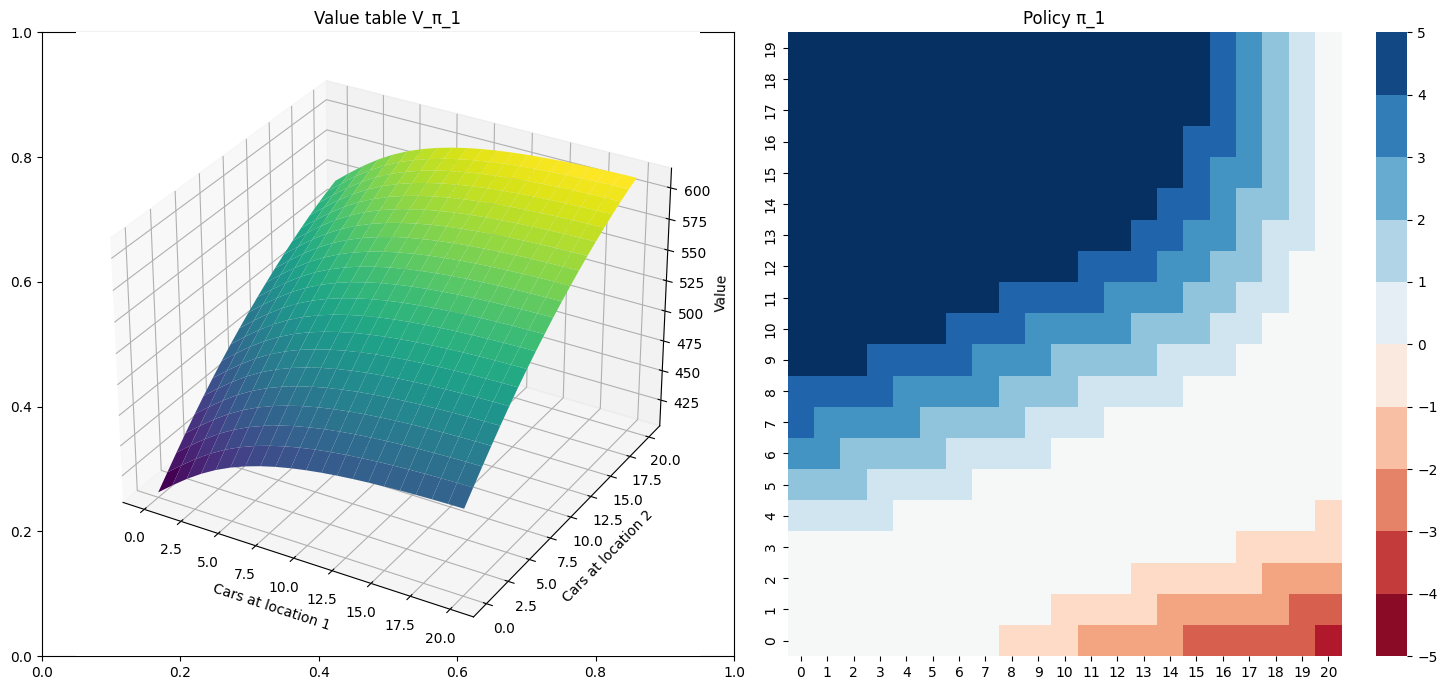

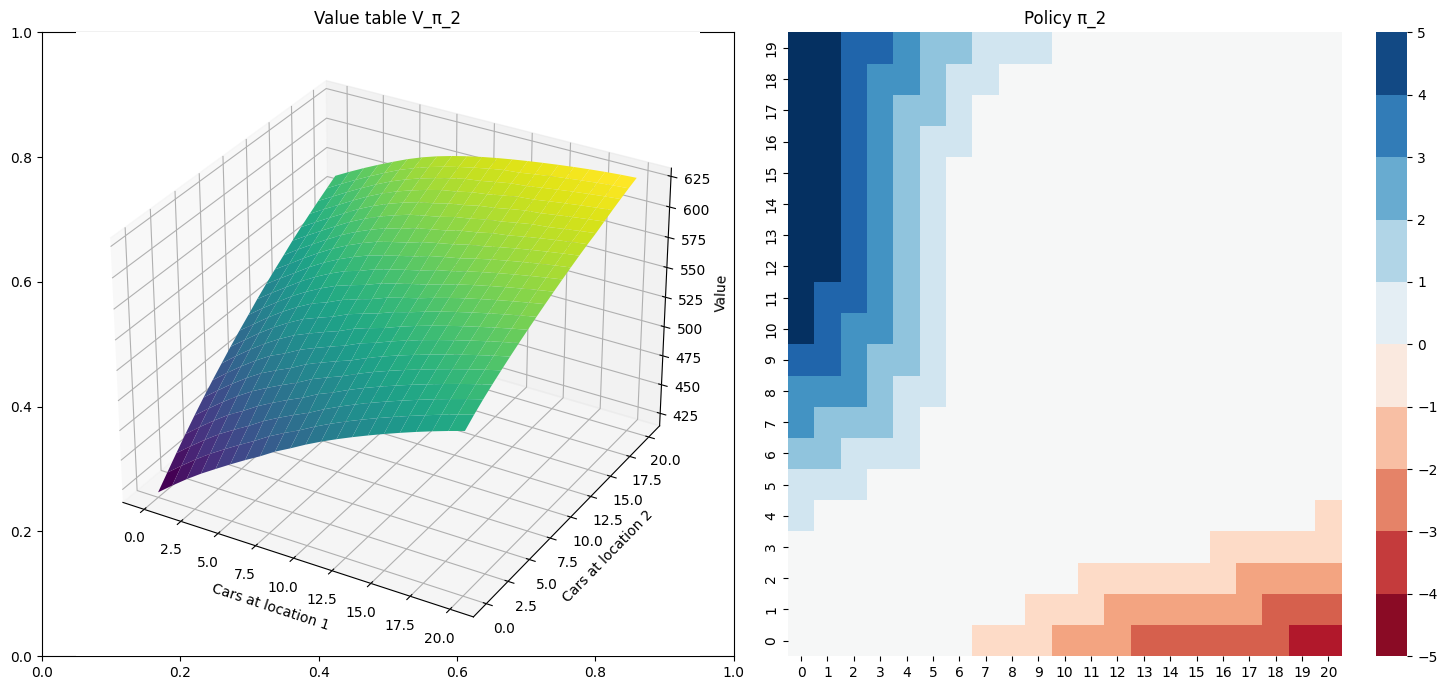

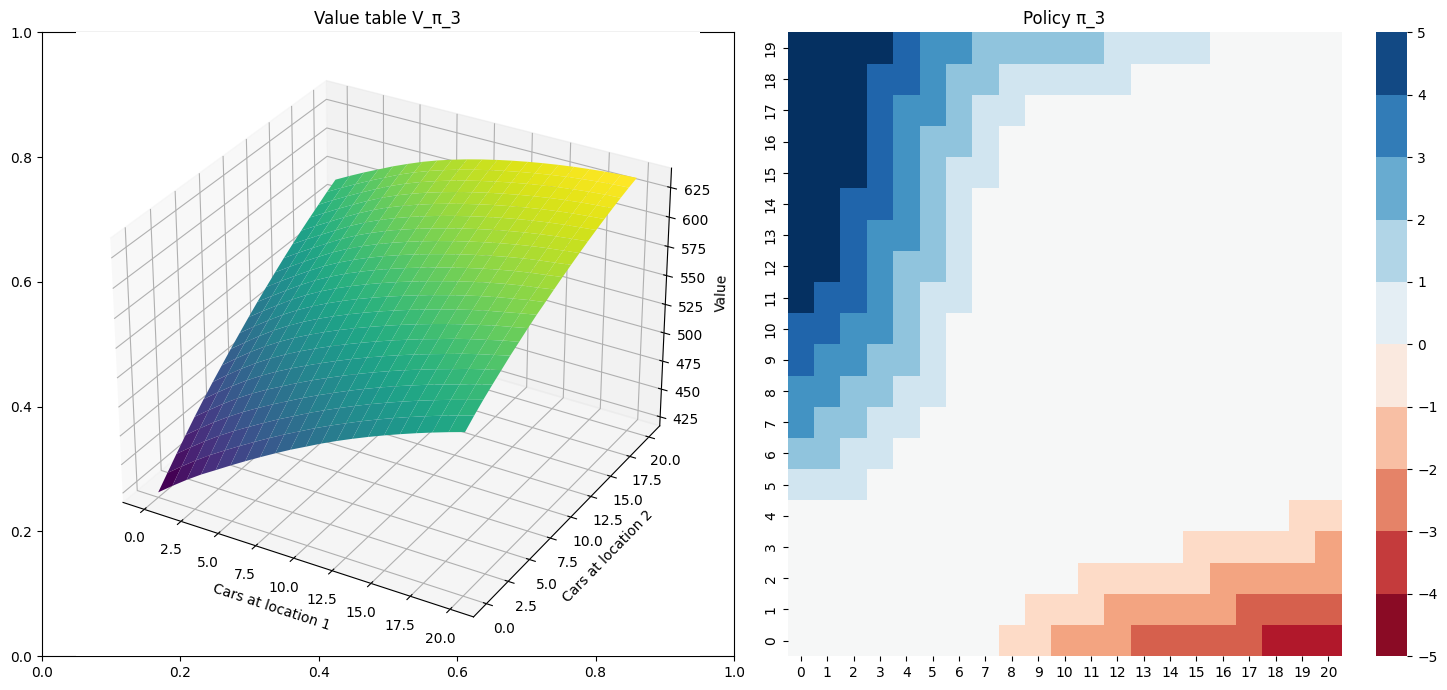

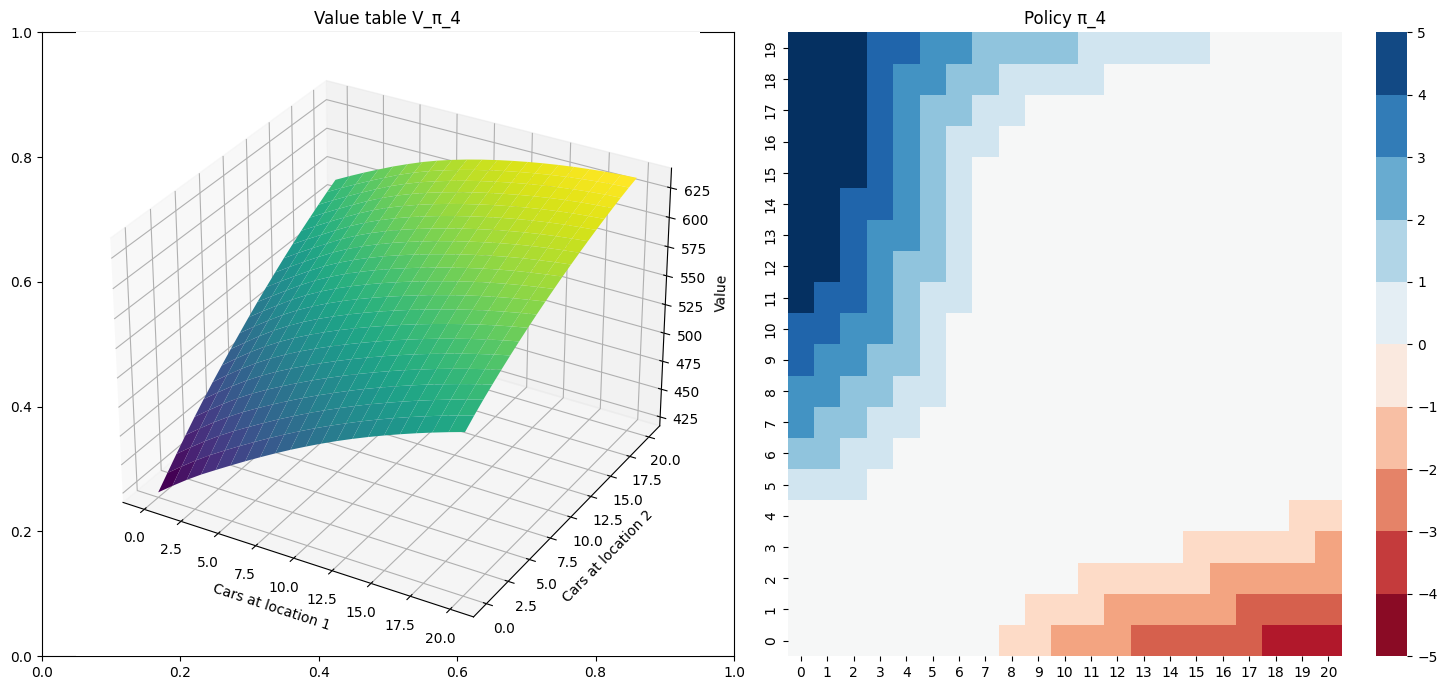

In [11]:
policy_iteration()

#### Value Iteration

In [12]:
def value_iteration():
    # Initialization
    global MAX_CARS, MAX_MOVE, THETA
    value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)

    while True: 
        old_value = np.copy(value)
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                action_list = list(range(-MAX_MOVE, MAX_MOVE + 1))
                state = [i, j]
                reward = []
                for action in action_list:
                    if (0 <= action <= i) or (-j <= action <= 0):
                        reward.append(expectation_reward(state, action, old_value))
                    else:
                        reward.append(-np.inf)
                value[i, j] = np.max(reward)
                policy[i, j] = action_list[np.argmax(reward)]
        delta = np.max(np.abs(value - old_value))
        if delta < THETA:
            break
    
    plot(policy, value, '*')
    
    return

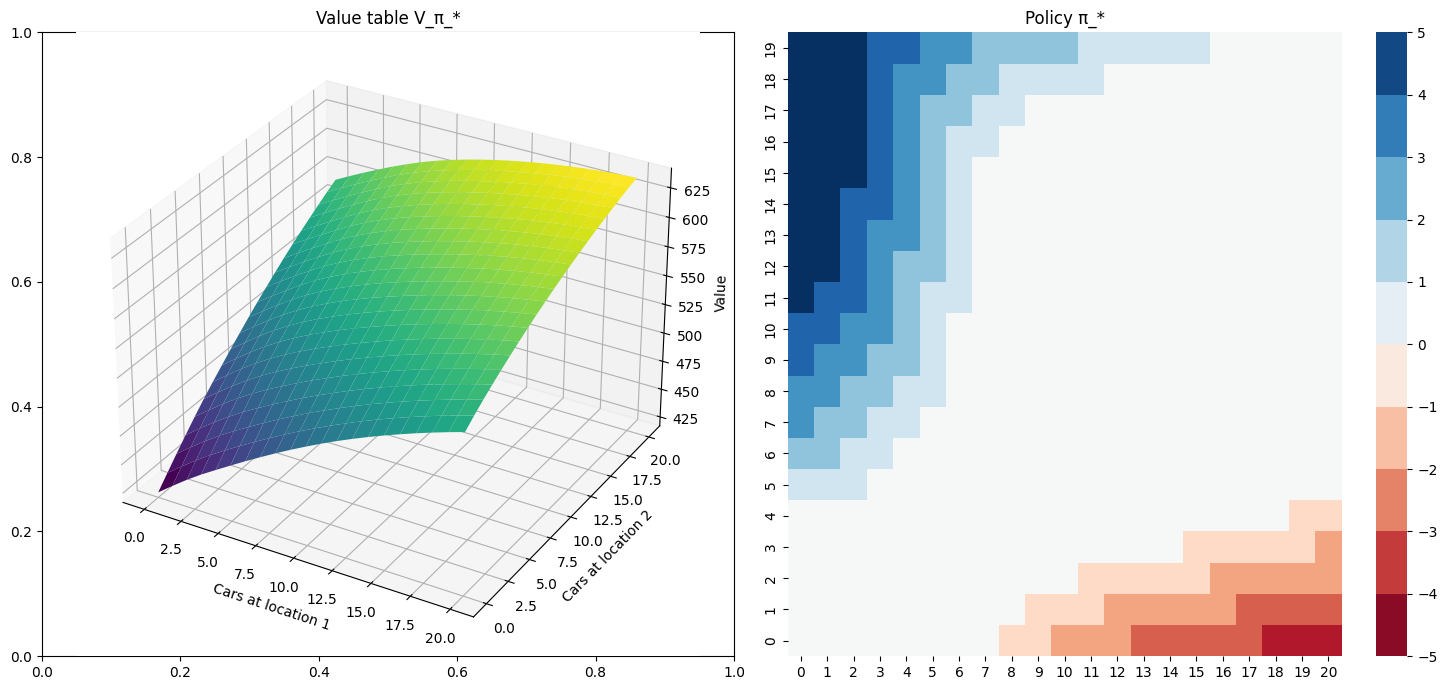

In [13]:
value_iteration()

# Exercise 4

In [14]:
class Grid:
    def __init__(self, size=4) -> None:
        self.size = size
        self.state = [i for i in range(1, size*size + 1)]
        self.action_list = ['up', 'down', 'left', 'right']
        self.terminal_state = [1, 10]
        self.current = None
        self.reward = -1

    def reset(self, start=16):
        self.current = start
        return self.current
    
    def step(self, action):
        old_state = self.current
        if self.current in self.terminal_state:
            return old_state, self.current, 0
        else:
            if action == 'up':
                if self.current <= self.size:
                    self.current = self.current
                else:
                    self.current -= self.size
            elif action == 'down':
                if self.current > self.size * (self.size - 1):
                    self.current = self.current
                else:
                    self.current += self.size
            elif action == 'left':
                if self.current % self.size == 1:
                    self.current = self.current
                else:
                    self.current -= 1
            else:
                if self.current % self.size == 0:
                    self.current = self.current
                else:
                    self.current += 1
            return old_state, self.current, self.reward
               

#### $V^{\pi}$ evaluated by the uniform policy 

In [15]:
def optimal_V_eval(grid, theta=1e-3, gamma=1):
    V = np.zeros(grid.size * grid.size + 1)
    iteration = 0
    while True:
        delta = 0
        for s in grid.state:
            if s in grid.terminal_state:
                continue
            v = V[s]
            v_new = 0
            for a in grid.action_list:
                grid.reset(s)
                _, next_state, reward = grid.step(a)
                v_new += 0.25 * (reward + gamma * V[next_state])
            V[s] = v_new
            delta = max(delta, abs(v - V[s]))
        iteration += 1
        if delta < theta:
            break

    return V, iteration

#### Every-visit MC ($S_{0}=16$)

In [16]:
def every_visit_non_exploring(grid, K, start=16):
    Ret = {s: [] for s in grid.state}
    v = np.zeros(grid.size * grid.size + 1)
    V = []

    for k in range(1, K + 1):
        grid.reset(start)
        episode_cache = []
        while grid.current not in grid.terminal_state:
            action = np.random.choice(grid.action_list)
            state, next_state, reward = grid.step(action)
            episode_cache.append((state, action, reward))
        ret = 0
        for s, _, r in reversed(episode_cache):
            ret += r
            Ret[s].append(ret)
            v[s] = np.mean(Ret[s])
        V.append(v.copy())
    
    return V

#### Every-visit MC (exploring starts)

In [17]:
def every_visit_exploring(grid, K):
    Ret = {s: [] for s in grid.state}
    v = np.zeros(grid.size * grid.size + 1)
    V = []

    for k in range(1, K + 1):
        start = np.random.choice(grid.state)
        grid.reset(start)
        episode_cache = []
        while grid.current not in grid.terminal_state:
            action = np.random.choice(grid.action_list)
            state, next_state, reward = grid.step(action)
            episode_cache.append((state, action, reward))
        ret = 0
        for s, _, r in reversed(episode_cache):
            ret += r
            Ret[s].append(ret)
            v[s] = np.mean(Ret[s])
        V.append(v.copy())
    
    return V

#### First-visit MC ($S_{0}=16$)

In [18]:
def first_visit_non_exploring(grid, K, start=16):
    Ret = {s: [] for s in grid.state}
    v = np.zeros(grid.size * grid.size + 1)
    V = []

    for k in range(1, K + 1):
        grid.reset(start)
        episode_cache = []
        while grid.current not in grid.terminal_state:
            action = np.random.choice(grid.action_list)
            state, next_state, reward = grid.step(action)
            episode_cache.append((state, action, reward))
        ret = 0
        visited_states = set()
        cumsum = []
        for _, _, r in reversed(episode_cache):
            ret += r
            cumsum.append(ret)
        cumsum.reverse()
        i = 0
        for s, _, r in episode_cache:
            if s not in visited_states:
                Ret[s].append(cumsum[i])
                visited_states.add(s)
                v[s] = np.mean(Ret[s])
            i += 1
        V.append(v.copy())
    
    return V

#### First-visit MC (exploring starts)

In [19]:
def first_visit_exploring(grid, K):
    Ret = {s: [] for s in grid.state}
    v = np.zeros(grid.size * grid.size + 1)
    V = []

    for k in range(1, K + 1):
        start = np.random.choice(grid.state)
        grid.reset(start)
        episode_cache = []
        while grid.current not in grid.terminal_state:
            action = np.random.choice(grid.action_list)
            state, next_state, reward = grid.step(action)
            episode_cache.append((state, action, reward))
        ret = 0
        visited_states = set()
        cumsum = []
        for _, _, r in reversed(episode_cache):
            ret += r
            cumsum.append(ret)
        cumsum.reverse()
        i = 0
        for s, _, r in episode_cache:
            if s not in visited_states:
                Ret[s].append(cumsum[i])
                visited_states.add(s)
                v[s] = np.mean(Ret[s])
            i += 1
        V.append(v.copy())
        
    return V

#### Compute $ε^{k}$ for $k \in K$

In [20]:
def compute_ε(V_, v):
    ε = np.zeros(len(v))
    for k in range(len(v)):
        ε[k] = np.nanmax(np.abs(V_ - v[k]))
    return ε

#### Plot ε

In [21]:
def plot_ε(every_non, every_ex, first_non, first_ex):
    plt.figure(figsize=(10,6))
    
    # Plotting for each method
    plt.plot(every_non, label='Every-Visit MC (Start=16)', color='red')
    plt.plot(every_ex, label='Every-Visit MC (Exploring Starts)', color='blue')
    plt.plot(first_non, label='First-Visit MC (Start=16)', color='green')
    plt.plot(first_ex, label='First-Visit MC (Exploring Starts)', color='purple')
    
    # Setting labels, title and legend
    plt.xlabel('Episodes')
    plt.ylabel('$\epsilon_k$ values')
    plt.title('$\epsilon_k$ values across episodes for different MC methods')
    plt.legend()
    plt.grid(True)
    
    plt.show()

Optimal Value Function V_pi converged in 78 iterations


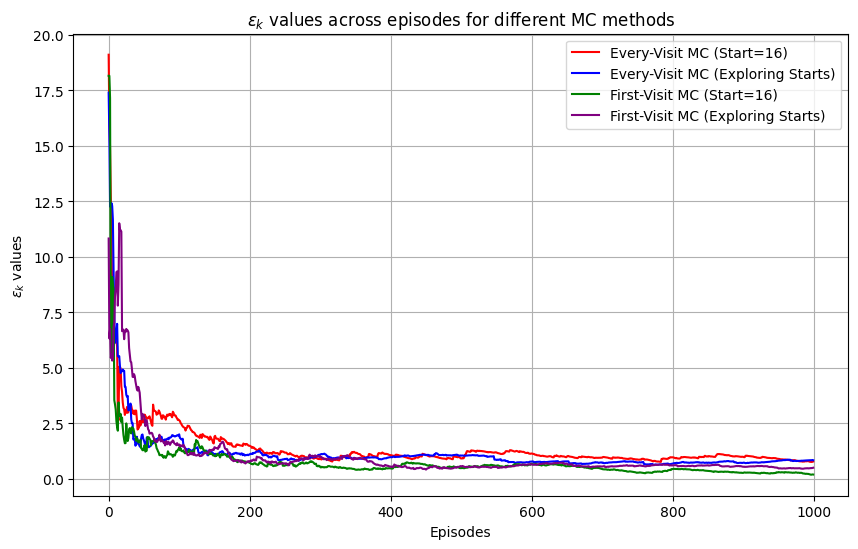

In [22]:
grid = Grid()
K = 1000
V_, iteration = optimal_V_eval(grid)
print(f"Optimal Value Function V_pi converged in {iteration} iterations")
V1, V2, V3, V4 = [], [], [], []
for i in range(10):
    v1 = every_visit_non_exploring(grid, K)
    v2 = every_visit_exploring(grid, K)
    v3 = first_visit_non_exploring(grid, K)
    v4 = first_visit_exploring(grid, K)
    V1.append(v1)
    V2.append(v2)
    V3.append(v3)
    V4.append(v4)
V1 = np.mean(np.array(V1), axis=0)
V2 = np.mean(np.array(V2), axis=0)
V3 = np.mean(np.array(V3), axis=0)
V4 = np.mean(np.array(V4), axis=0)
plot_ε(compute_ε(V_, V1), compute_ε(V_, V2), compute_ε(V_, V3), compute_ε(V_, V4))

In [23]:
print(V_)

[  0.           0.          -9.79949805 -16.39439693 -19.85682332
  -6.69447484  -9.00564813 -15.52929495 -19.32206757  -7.07852027
   0.         -13.39649575 -18.58174933 -10.54159938 -10.00566244
 -15.47634181 -19.02826154]


# Exercise 5

#### Every-visit MC Q evaluation ($S_{0}=16$)

In [24]:
def Q_every_visit_non_exploring(grid, K, start=16):
    Ret = {(s, a) : [] for s in grid.state for a in grid.action_list}
    q = np.zeros((grid.size * grid.size, len(grid.action_list)))
    v = np.zeros(grid.size * grid.size + 1)
    V = []

    for k in range(1, K + 1):
        grid.reset(start)
        episode_cache = []
        while grid.current not in grid.terminal_state:
            action = np.random.choice(grid.action_list)
            state, next_state, reward = grid.step(action)
            episode_cache.append((state, action, reward))
        ret = 0
        for s, a, r in reversed(episode_cache):
            ret += r
            Ret[(s, a)].append(ret)
            q[s-1, grid.action_list.index(a)] = np.mean(Ret[(s, a)])
            # v[s] = np.nanmax(q[s-1])
            v[s] = np.mean(q[s-1])
        V.append(v.copy())
    
    return V

#### Every-visit MC Q evaluation (exploring starts)

In [25]:
def Q_every_visit_exploring(grid, K):
    Ret = {(s, a) : [] for s in grid.state for a in grid.action_list}
    q = np.zeros((grid.size * grid.size, len(grid.action_list)))
    v = np.zeros(grid.size * grid.size + 1)
    V = []

    for k in range(1, K + 1):
        grid.reset(np.random.choice(grid.state))
        episode_cache = []
        while grid.current not in grid.terminal_state:
            action = np.random.choice(grid.action_list)
            state, next_state, reward = grid.step(action)
            episode_cache.append((state, action, reward))
        ret = 0
        for s, a, r in reversed(episode_cache):
            ret += r
            Ret[(s, a)].append(ret)
            q[s-1, grid.action_list.index(a)] = np.mean(Ret[(s, a)])
            # v[s] = np.nanmax(q[s-1])
            v[s] = np.mean(q[s-1])
        V.append(v.copy())
    
    return V

#### First-visit MC Q evaluation ($S_{0}=16$)

In [26]:
def Q_first_visit_non_exploring(grid, K, start=16):
    Ret = {(s, a) : [] for s in grid.state for a in grid.action_list}
    q = np.zeros((grid.size * grid.size, len(grid.action_list)))
    v = np.zeros(grid.size * grid.size + 1)
    V = []

    for k in range(1, K + 1):
        grid.reset(start)
        episode_cache = []
        while grid.current not in grid.terminal_state:
            action = np.random.choice(grid.action_list)
            state, next_state, reward = grid.step(action)
            episode_cache.append((state, action, reward))
        ret = 0
        visited_states = set()
        cumsum = []
        for _, _, r in reversed(episode_cache):
            ret += r
            cumsum.append(ret)
        cumsum.reverse()
        i = 0
        for s, a, r in episode_cache:
            if (s, a) not in visited_states:
                Ret[(s, a)].append(cumsum[i])
                visited_states.add((s, a))
                q[s-1, grid.action_list.index(a)] = np.mean(Ret[(s, a)])
                # v[s] = np.nanmax(q[s-1])
                v[s] = np.mean(q[s-1])
            i += 1
        V.append(v.copy())

    return V

#### First-visit MC Q evaluation (exploring starts)

In [27]:
def Q_first_visit_exploring(grid, K):
    Ret = {(s, a) : [] for s in grid.state for a in grid.action_list}
    q = np.zeros((grid.size * grid.size, len(grid.action_list)))
    v = np.zeros(grid.size * grid.size + 1)
    V = []

    for k in range(1, K + 1):
        grid.reset(np.random.choice(grid.state))
        episode_cache = []
        while grid.current not in grid.terminal_state:
            action = np.random.choice(grid.action_list)
            state, next_state, reward = grid.step(action)
            episode_cache.append((state, action, reward))
        ret = 0
        visited_states = set()
        cumsum = []
        for _, _, r in reversed(episode_cache):
            ret += r
            cumsum.append(ret)
        cumsum.reverse()
        i = 0
        for s, a, r in episode_cache:
            if (s, a) not in visited_states:
                Ret[(s, a)].append(cumsum[i])
                visited_states.add((s, a))
                q[s-1, grid.action_list.index(a)] = np.mean(Ret[(s, a)])
                # v[s] = np.nanmax(q[s-1])
                v[s] = np.mean(q[s-1])
            i += 1
        V.append(v.copy())
    
    return V

#### plot $V$ 

In [28]:
def plot_V(V, every_non, every_ex, first_non, first_ex):
    plt.figure(figsize=(10,6))
    
    # Plotting for each method
    plt.plot(every_non, label='Every-Visit MC (Start=16)', color='red')
    plt.plot(every_ex, label='Every-Visit MC (Exploring Starts)', color='blue')
    plt.plot(first_non, label='First-Visit MC (Start=16)', color='green')
    plt.plot(first_ex, label='First-Visit MC (Exploring Starts)', color='purple')
    plt.plot(V, label='Optimal Value', color='black')
    
    # Setting labels, title and legend
    plt.xlabel('states')
    plt.ylabel('value')
    plt.title('$V$ function after K episodes for different MC methods')
    plt.legend()
    plt.grid(True)
    
    plt.show()

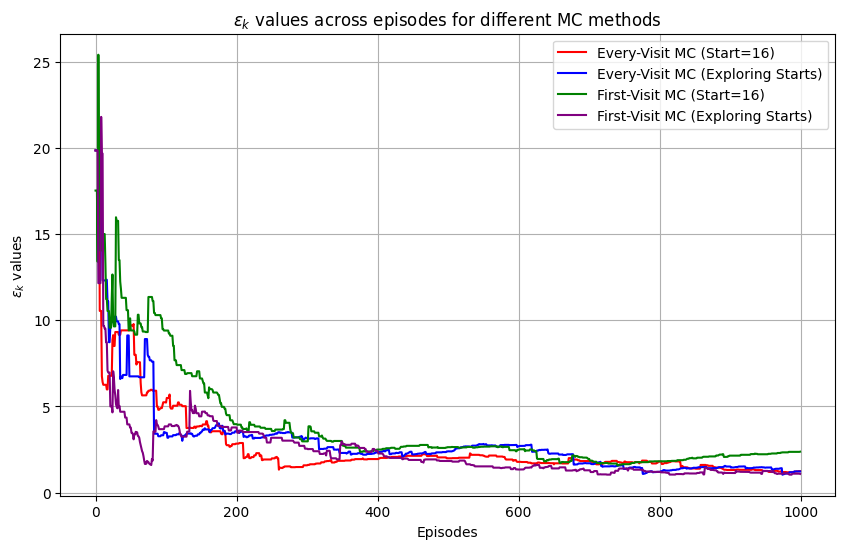

In [29]:
grid = Grid()
K = 1000
plot_ε(compute_ε(V_, Q_every_visit_exploring(grid, K)), compute_ε(V_, Q_every_visit_non_exploring(grid, K)), \
       compute_ε(V_, Q_first_visit_exploring(grid, K)), compute_ε(V_, Q_first_visit_non_exploring(grid, K)))

# Exercise 6

In [30]:
def MC_Q_eval(grid, policy, K):
    ### evaluation
    Q = {(s, a): 0 for s in grid.state for a in grid.action_list}
    Ret = {(s, a): [] for s in grid.state for a in grid.action_list}

    for _ in range(K):
        start = np.random.choice(grid.state)
        grid.reset(start)
        episode_cache = []
        
        while grid.current not in grid.terminal_state:
            action = np.random.choice(grid.action_list, p=policy[grid.current])
            current_state, _, reward = grid.step(action)
            episode_cache.append((current_state, action, reward))
        
        ret = 0
        visited_states = set()
        cumsum = []
        for _, _, r in reversed(episode_cache):
            ret += r
            cumsum.append(ret)
        cumsum.reverse()
        i = 0
        for s, a, r in episode_cache:
            if (s, a) not in visited_states:
                Ret[(s, a)].append(cumsum[i])
                Q[(s, a)] = np.mean(Ret[(s, a)])
                visited_states.add((s, a))
            i += 1
    return Q

In [31]:
def MC_Q_policy_iteration(grid, K, episode_iter):

    # Initialization
    policy = {s: [1/4,1/4,1/4,1/4] for s in grid.state if s not in grid.terminal_state}
    for s in grid.terminal_state:
        policy[s] = [0,0,0,0] 
    
    for _ in range(K):
        # Policy Evaluation
        Q = MC_Q_eval(grid, policy, episode_iter)
            
        # Policy Improvement
        for s in grid.state:
            if s in grid.terminal_state:
                continue
            best_value = np.nanmax(np.asarray([Q[(s, a)] for a in grid.action_list]))
            for a in grid.action_list:
                index = grid.action_list.index(a)
                if Q[(s, a)] == best_value:
                    policy[s][index] = 1
                else:
                    policy[s][index] = 0
        for s in grid.state:
            if s not in grid.terminal_state:
                sum_prob = np.sum(policy[s])
                policy[s] = [policy[s][a]/sum_prob for a in range(len(grid.action_list))]
    
    return policy

#### Plot policy

In [32]:
def visualize_policy(grid, policy):
    grid_size = 4
    arrow_map = {
        'up': '↑',
        'down': '↓',
        'left': '←',
        'right': '→'
    }

    fig, ax = plt.subplots(figsize=(grid_size+1, grid_size+1))
    
    for s in policy:
        if s in grid.terminal_state:
            continue
        # Convert the state to 2D coordinates
        x, y = (s - 1) % grid_size, grid_size - 1 - (s - 1) // grid_size
        
        # Extract the action probabilities from the policy and find the maximum action
        action_probs = policy[s]
        max_action = grid.action_list[np.argmax(action_probs)]
        
        # Put the corresponding arrow in the grid
        ax.text(x + 0.5, y + 0.5, arrow_map[max_action], 
                va='center', ha='center', fontsize=15)

    for s in grid.terminal_state:
        x, y = (s - 1) % grid_size, grid_size - 1 - (s - 1) // grid_size
        ax.text(x + 0.5, y + 0.5, 'T', va='center', ha='center', fontsize=15, color='red')

    # Draw gridlines
    ax.set_xticks(np.arange(grid_size+1))
    ax.set_yticks(np.arange(grid_size+1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='both')
    ax.set_title("Policy Visualization")

    plt.show()

In [33]:
grid_3 = Grid()
K = 1
episode_iter = 10000
policy = MC_Q_policy_iteration(grid_3, K, episode_iter)
# print(policy)

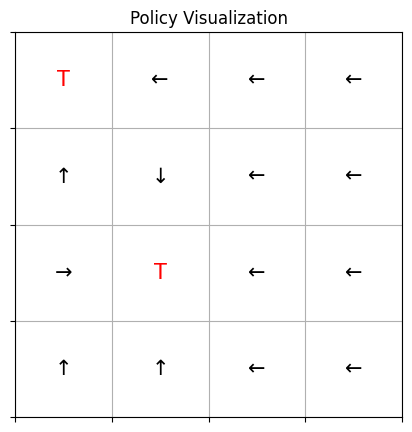

In [34]:
visualize_policy(grid_3, policy)

In [35]:
print(policy)

{2: [0.0, 0.0, 1.0, 0.0], 3: [0.0, 0.0, 1.0, 0.0], 4: [0.0, 0.0, 1.0, 0.0], 5: [1.0, 0.0, 0.0, 0.0], 6: [0.0, 1.0, 0.0, 0.0], 7: [0.0, 0.0, 1.0, 0.0], 8: [0.0, 0.0, 1.0, 0.0], 9: [0.0, 0.0, 0.0, 1.0], 11: [0.0, 0.0, 1.0, 0.0], 12: [0.0, 0.0, 1.0, 0.0], 13: [1.0, 0.0, 0.0, 0.0], 14: [1.0, 0.0, 0.0, 0.0], 15: [0.0, 0.0, 1.0, 0.0], 16: [0.0, 0.0, 1.0, 0.0], 1: [0, 0, 0, 0], 10: [0, 0, 0, 0]}
